In [1]:
#Data manipulation
import pandas as pd
import numpy as np
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
#Models
from sklearn.ensemble import RandomForestRegressor
#Scores
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# 1 - EDA and preprocessing

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
stores=pd.read_csv("stores.csv")
features=pd.read_csv("features.csv")

In [3]:
print("Train:",train.shape)
print("Test:",test.shape)
print("Stores:",stores.shape)
print("Features:",features.shape)

Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Features: (8190, 12)


## 1.1 - Joining tables
- **Stores**: indicates size and type of each store
- **Features**: some characteristics for every date

In [4]:
train=train.merge(stores,on="Store")
test=test.merge(stores,on="Store")

In [5]:
train=pd.merge(train, features, how='left', on=["Store", "Date"])
test=pd.merge(test, features, how='left', on=["Store", "Date"])

In [6]:
train.drop("IsHoliday_y",axis=1,inplace=True)
test.drop("IsHoliday_y",axis=1,inplace=True)

In [7]:
train.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)
test.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)

In [8]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [9]:
test.head(5)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


I need to build this column only for the submission file

In [10]:
submission=pd.DataFrame()
submission["Id"]=test["Store"].astype(str)+"_"+test["Dept"].astype(str)+"_"+test["Date"].astype(str)

In [11]:
print("Train data range is between {0} and {1}".format(train["Date"].min(), test["Date"].max()))
print("----------------------------------------------------------")
print("Train days = {0}".format(pd.to_datetime(train["Date"]).max() - pd.to_datetime(train["Date"]).min()))
print("----------------------------------------------------------\n\n")
print("Predict range is between {0} and {1}".format(test["Date"].min(), test["Date"].max()))
print("----------------------------------------------------------")
print("Predict days = {0}".format(pd.to_datetime(test["Date"]).max() - pd.to_datetime(test["Date"]).min()))

Train data range is between 2010-02-05 and 2013-07-26
----------------------------------------------------------
Train days = 994 days 00:00:00
----------------------------------------------------------


Predict range is between 2012-11-02 and 2013-07-26
----------------------------------------------------------
Predict days = 266 days 00:00:00


## 1.2 - Types

In [12]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
dtype: object

- Change Date to datetime
- Change IsHoliday to 1 and 0

In [13]:
train["Date"]=pd.to_datetime(train["Date"])
test["Date"]=pd.to_datetime(test["Date"])

In [14]:
train["IsHoliday"]=np.where(train["IsHoliday"]==True,1,0)
test["IsHoliday"]=np.where(test["IsHoliday"]==True,1,0)

## 1.3 - Categorical features

### 1.3.1 - Store, type and size

Store

In [15]:
train["Store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

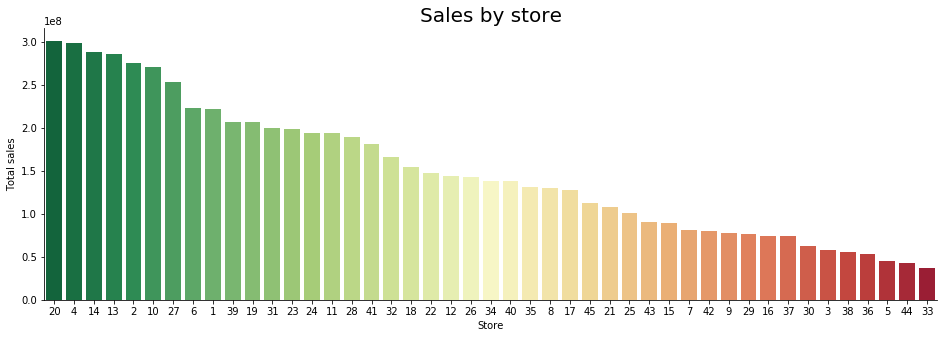

In [16]:
sales_by_store=train.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Total sales").sort_values(by="Total sales",ascending=False)
plt.figure(figsize=(16,5))
sns.barplot(sales_by_store["Store"],sales_by_store["Total sales"],palette="RdYlGn_r",order=sales_by_store["Store"].tolist())
sns.despine()
plt.title("Sales by store",fontsize=20)
plt.show()

In [17]:
sales_by_store["Cum Sales"]=sales_by_store["Total sales"].cumsum()
sales_by_store["Pct sales"]=sales_by_store["Cum Sales"]/train["Weekly_Sales"].sum()
stores_eighty_pct_sales=sales_by_store[sales_by_store["Pct sales"]<=0.81]["Store"].tolist()
print("The first {0} stores plotted represents the 80% of the total sales".format(len(stores_eighty_pct_sales)))

The first 27 stores plotted represents the 80% of the total sales


In [18]:
train.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Sales by store").set_index("Store").describe()

,Sales by store
count,4.500000e+01
mean,1.497160e+08
std,7.816756e+07
min,3.716022e+07
25%,7.956575e+07
50%,1.382498e+08
75%,1.996139e+08
max,3.013978e+08


Type

In [19]:
train["Type"].value_counts()/train["Type"].count()*100

A    51.113220
B    38.782409
C    10.104372
Name: Type, dtype: float64

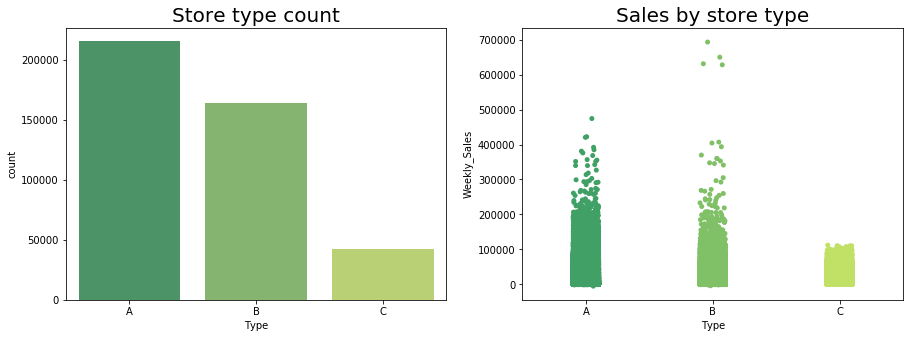

In [20]:
f, ax = plt.subplots(ncols=2,sharey=False,figsize=(15,5))

sns.countplot(train["Type"],palette="summer",ax=ax[0])
ax[0].set_title("Store type count",fontsize=20)

sns.stripplot(train["Type"],train["Weekly_Sales"],palette="summer",ax=ax[1])
ax[1].set_title("Sales by store type",fontsize=20)

plt.show()

In [21]:
train.groupby("Type")["Size"].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,215478.0,182231.285486,41534.529330,39690.0,158114.0,202505.0,203819.0,219622.0
B,163495.0,101818.735827,30921.779415,34875.0,93188.0,114533.0,123737.0,140167.0
C,42597.0,40535.725286,1194.434302,39690.0,39690.0,39910.0,41062.0,42988.0


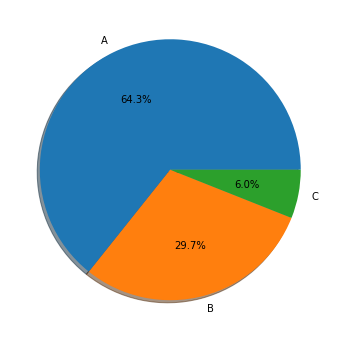

In [22]:
types_pct=(train.groupby("Type")["Weekly_Sales"].sum()/train["Weekly_Sales"].sum()*100).reset_index(name="%")
plt.figure(figsize=(6,6))
plt.pie(types_pct["%"],labels=types_pct["Type"],autopct="%1.1f%%",shadow=True)
plt.show()

- We see that there are more type A stores (51%) and C has the least quantity of stores (10%)
- The stores that sells the most are type B, and the least type C
- The type A sells 64% of the total sales, 30% B type and only a 6% C type
- The type C has a very uniform size, but A and B don't, so we can create a Size feature (Big,medium,small) in order to improve our model accuracy

### 1.3.2 - Dept

In [23]:
print("There are {0} departaments".format(len(train["Dept"].unique())))

There are 81 departaments


In [24]:
sales_by_dept=train.groupby("Dept")["Weekly_Sales"].sum().reset_index(name="Total sales").sort_values(by="Total sales",ascending=False)

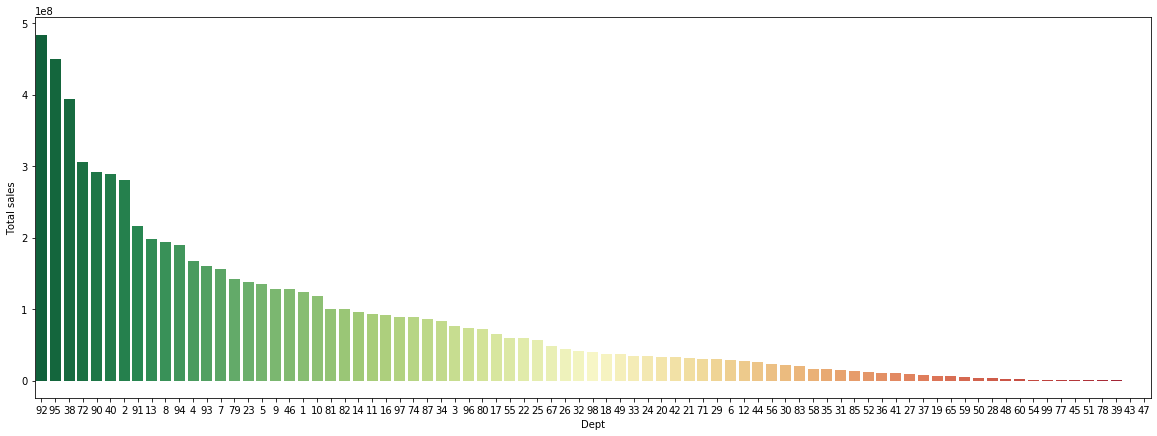

In [25]:
plt.figure(figsize=(20,7))
sns.barplot(sales_by_dept["Dept"],sales_by_dept["Total sales"],order=sales_by_dept["Dept"].tolist(),palette="RdYlGn_r")
plt.show()

In [26]:
sales_by_dept["Cum Sales"]=sales_by_dept["Total sales"].cumsum()
sales_by_dept["Pct sales"]=sales_by_dept["Cum Sales"]/train["Weekly_Sales"].sum()
dept_eighty_pct_sales=sales_by_dept[sales_by_dept["Pct sales"]<=0.81]["Dept"].tolist()
print("The first {0} departaments plotted represents the 80% of the total sales".format(len(dept_eighty_pct_sales)))

The first 29 departaments plotted represents the 80% of the total sales


In [27]:
train.groupby("Dept")["Weekly_Sales"].sum().reset_index(name="Sales by dept").set_index("Dept").describe()

,Sales by dept
count,8.100000e+01
mean,8.317554e+07
std,1.035439e+08
min,-4.962930e+03
25%,1.208694e+07
50%,3.982892e+07
75%,1.178974e+08
max,4.839433e+08


### 1.3.3 - Date and IsHoliday

In [28]:
sales_by_date=train.groupby("Date")["Weekly_Sales"].sum().reset_index(name="Sales")

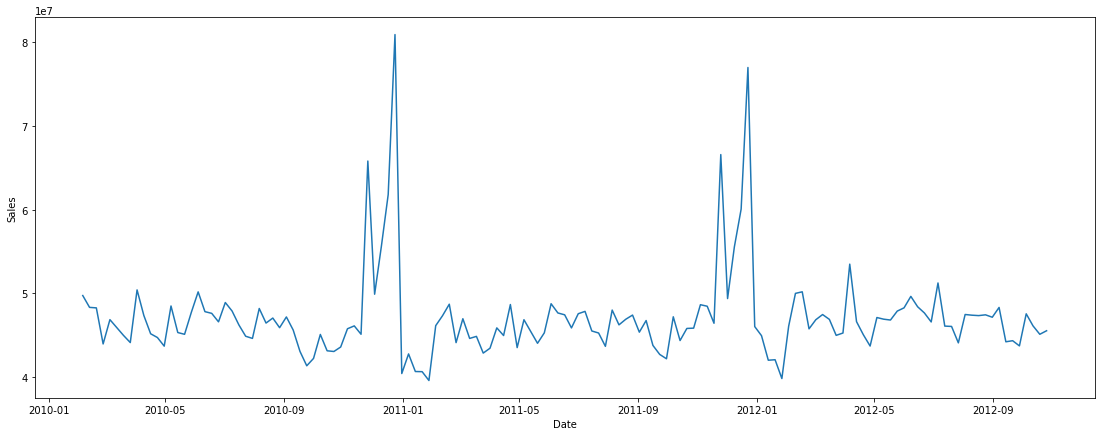

In [74]:
plt.figure(figsize=(19,7))
sns.lineplot(sales_by_date["Date"],sales_by_date["Sales"])
plt.show()

In [30]:
train["Date"].dt.weekday.unique()

array([4])

- They give us the weekly sales every Friday.
- Sales have not changed between years.

This for creates a column for each attribute of the date.

In [31]:
dt_cols=["Year","Month","weekofyear","Week","dayofyear","quarter",
         "is_month_start","is_month_end","is_quarter_start","is_quarter_end","is_year_start","is_year_end"]

for col in dt_cols:
    train[col]=getattr(train["Date"].dt, col.lower())
    test[col]=getattr(test["Date"].dt, col.lower())

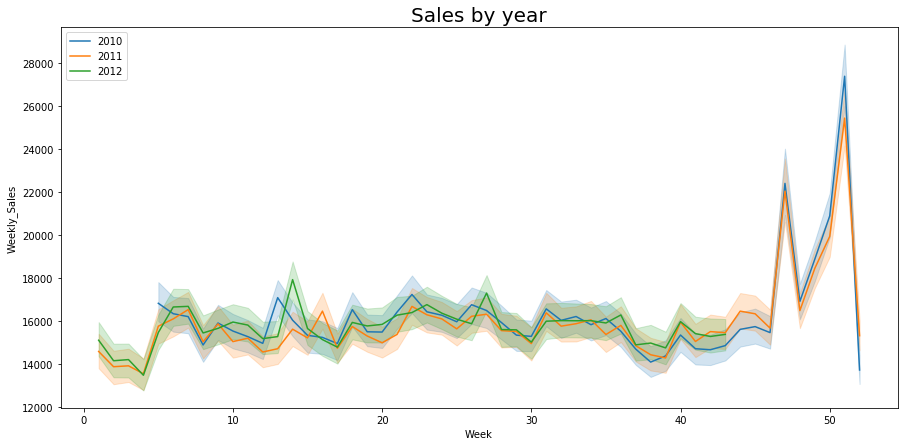

In [32]:
plt.figure(figsize=(15,7))
sns.lineplot(train[train["Year"]==2010]["Week"],train[train["Year"]==2010]["Weekly_Sales"],label="2010")
sns.lineplot(train[train["Year"]==2011]["Week"],train[train["Year"]==2011]["Weekly_Sales"],label="2011")
sns.lineplot(train[train["Year"]==2012]["Week"],train[train["Year"]==2012]["Weekly_Sales"],label="2012")
plt.title("Sales by year",fontsize=20)
plt.legend()
plt.show()

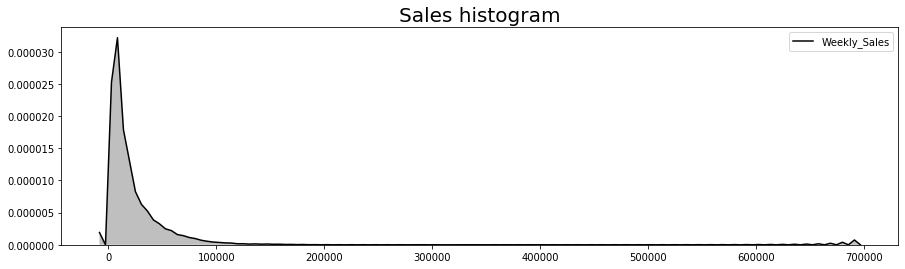

We see a target with a high skeweness


In [33]:
plt.figure(figsize=(15,4))
sns.kdeplot(train["Weekly_Sales"],shade=True,color="k")
plt.title("Sales histogram",fontsize=20)
plt.show()
print("We see a target with a high skeweness")

In [34]:
holiday_sales=train[train["IsHoliday"]==1].groupby("Date")["Weekly_Sales"].sum().reset_index(name="Sales on holidays")

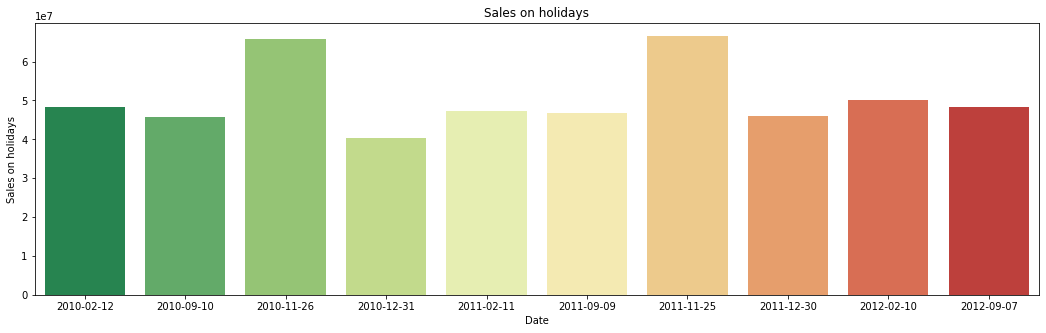

In [35]:
plt.figure(figsize=(18,5))
sns.barplot(holiday_sales["Date"].dt.date,holiday_sales["Sales on holidays"],palette="RdYlGn_r")
plt.title("Sales on holidays")
plt.show()

There are more important the weeks before holidays, so lets plot them.

In [36]:
holiday_sales["Week before holiday"]=holiday_sales["Date"].dt.date-pd.DateOffset(weeks=1)
holiday_sales["Sales week before holiday"]=train[train["Date"].isin(holiday_sales["Week before holiday"])].groupby("Date")["Weekly_Sales"].sum().reset_index(name="sales")["sales"]

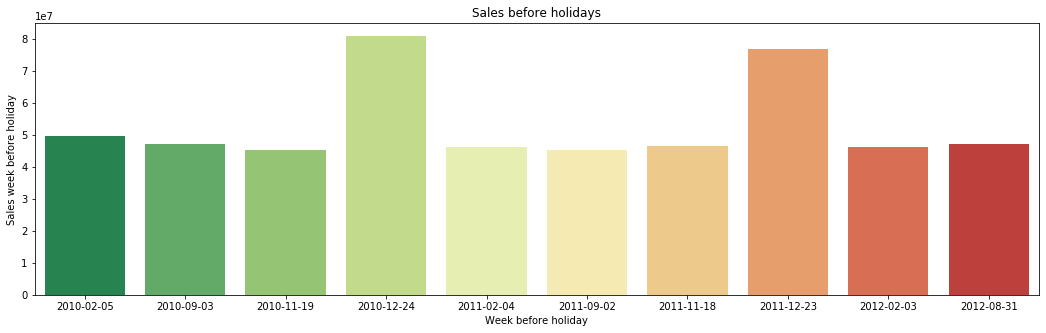

In [37]:
plt.figure(figsize=(18,5))
sns.barplot(holiday_sales["Week before holiday"].dt.date,holiday_sales["Sales week before holiday"],palette="RdYlGn_r")
plt.title("Sales before holidays")
plt.show()

## 1.4 - Numeric features

### 1.4.1 - Temperature

Each Store is in a different place, so stores has different Tª in the same day. So lets take the mean for all days and plot them

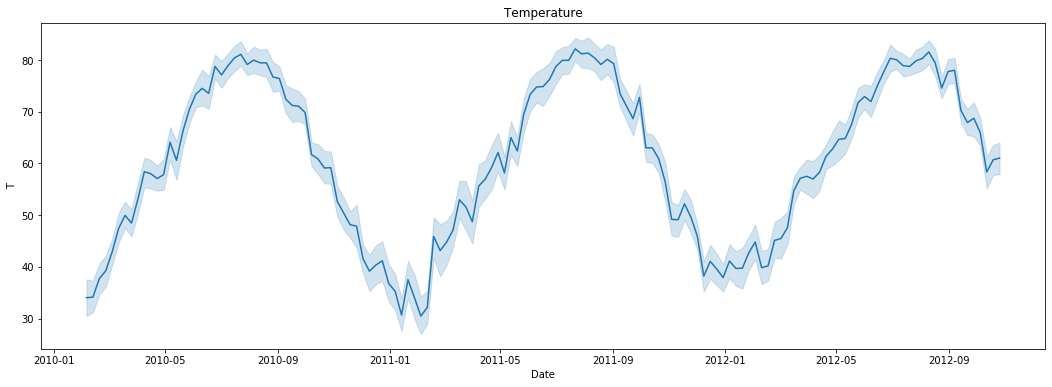

In [38]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Temperature"].mean().reset_index(name="T")["Date"],
             train.groupby(["Date","Store"])["Temperature"].mean().reset_index(name="T")["T"])
plt.title("Temperature")
plt.show()

In [39]:
train["Temperature"].describe()

count    421570.000000
mean         60.090059
std          18.447931
min          -2.060000
25%          46.680000
50%          62.090000
75%          74.280000
max         100.140000
Name: Temperature, dtype: float64

### 1.4.2 - Fuel_Price

Also, the Fuel_Price varies depending the store and the date, so we take the mean to plot.

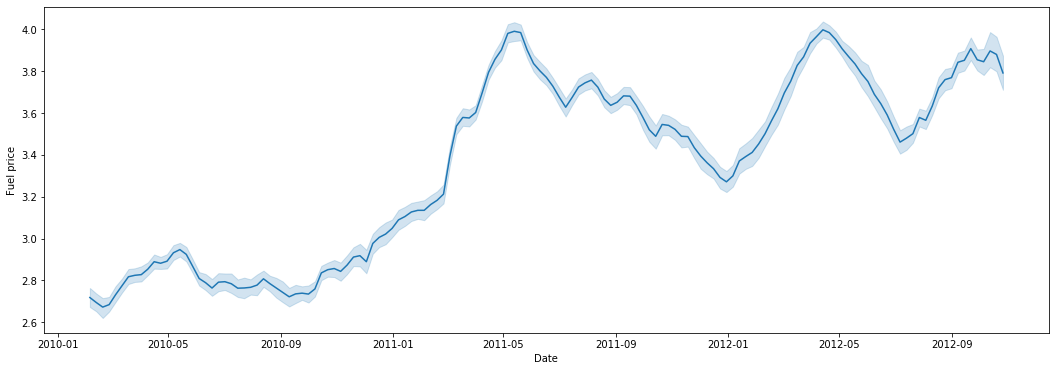

In [40]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Fuel_Price"].mean().reset_index(name="Fuel price")["Date"],
            train.groupby(["Date","Store"])["Fuel_Price"].mean().reset_index(name="Fuel price")["Fuel price"])
plt.show()

### 1.4.3 - CPI and unemployment

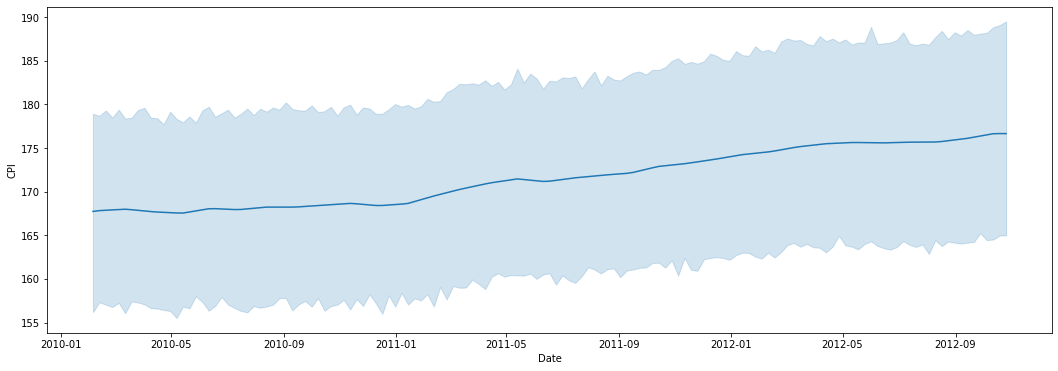

In [41]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["CPI"].mean().reset_index(name="CPI")["Date"],
            train.groupby(["Date","Store"])["CPI"].mean().reset_index(name="CPI")["CPI"])
plt.show()

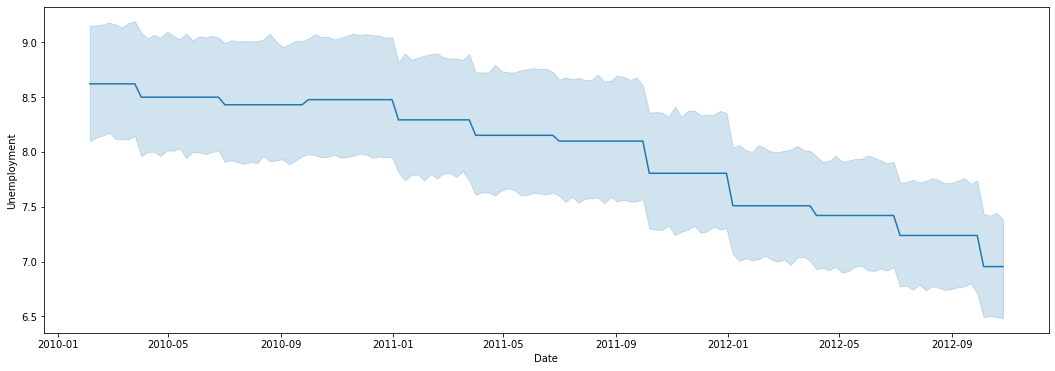

In [42]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Unemployment"].mean().reset_index(name="Unemployment")["Date"],
            train.groupby(["Date","Store"])["Unemployment"].mean().reset_index(name="Unemployment")["Unemployment"])
plt.show()

- The CPI is growing and the Unemployment is falling.
- The stores have differents CPI and Unemployments rates.

### 1.4.4 - Markdown
***MarkDown1-5:*** anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

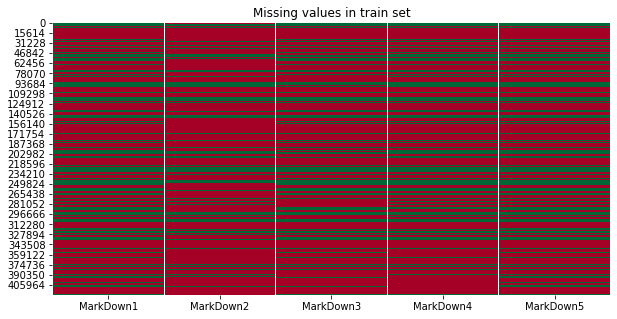

Percentage of missing values
MarkDown1    64.257181
MarkDown2    73.611025
MarkDown3    67.480845
MarkDown4    67.984676
MarkDown5    64.079038
dtype: float64


In [43]:
plt.figure(figsize=(10,5))
sns.heatmap(train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].isnull(),cbar=False,cmap="RdYlGn_r")
plt.title("Missing values in train set")
plt.show()

print("Percentage of missing values")
print(train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].isna().sum()/len(train)*100)


In [44]:
print("There are {0} rows with some MarkDown negative".format(
    
    len(train[(train["MarkDown1"]<0) | (train["MarkDown2"]<0) | 
        (train["MarkDown3"]<0) | (train["MarkDown4"]<0) |
        (train["MarkDown5"]<0)])
))

There are 1568 rows with some MarkDown negative


- I will create a new feature TotalMarkDown.
- After runnning model, this can be a feature to tune.

### 1.4.5 - Correlations

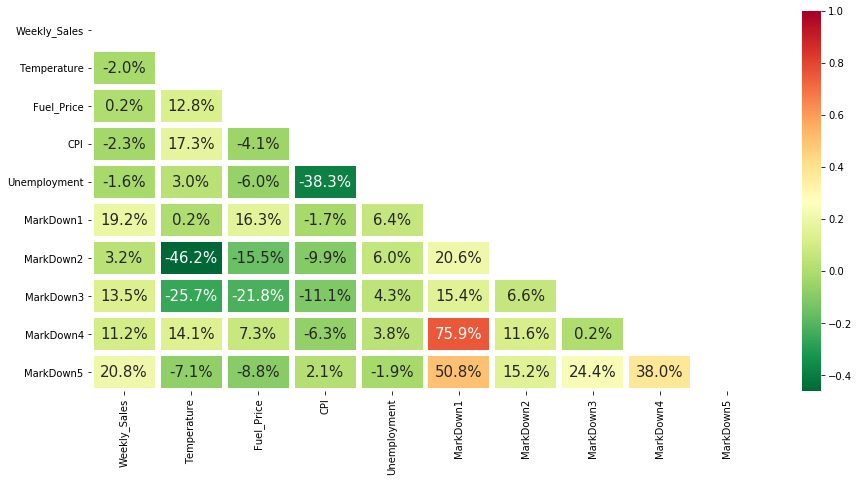

In [45]:
corr=train[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment",
            "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].corr(method="spearman")

plt.figure(figsize=(15,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap="RdYlGn_r",annot=True,linewidths=5,mask=mask,fmt = '.1%',annot_kws={"size": 15})
plt.show()

## 1.5 - Preprocessing

### 1.5.1 - Missing values

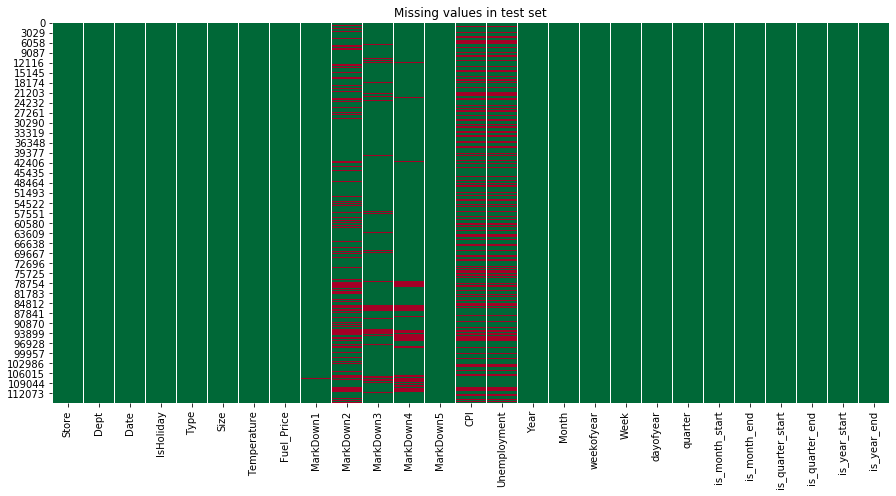

In [46]:
plt.figure(figsize=(15,7))
sns.heatmap(test.isnull(),cbar=False,cmap="RdYlGn_r")
plt.title("Missing values in test set")
plt.show()

#### 1.5.1.1 Markdowns
Filled with 0 and added a missing flag

In [47]:
markdowns_cols=["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]
for col in markdowns_cols:
    train[col+"_NaN"]=train[col].isnull()
    test[col+"_NaN"]=test[col].isnull()

In [48]:
train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]=train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].copy().fillna(0)
test[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]=test[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].copy().fillna(0)

#### 1.5.1.2 CPI and Unemployment
For this features we needn't a flag, their are going to be filled with a IterativeImputer using a regression.

In [49]:
imputer=IterativeImputer(estimator=BayesianRidge(),random_state=26)
imputed_values=imputer.fit_transform(test[["Store","Dept","Year","Month","quarter","CPI","Unemployment"]])

In [50]:
test[["CPI","Unemployment"]]=imputed_values[:,[5,6]]

### 1.5.2 Categorical features

In [51]:
train["Type"]=train["Type"].astype("category")
test["Type"]=test["Type"].astype("category")

In [52]:
train["Type"].cat.codes

0         0
1         0
2         0
3         0
4         0
         ..
421565    1
421566    1
421567    1
421568    1
421569    1
Length: 421570, dtype: int8

In [53]:
train["Type"]=train["Type"].cat.codes
test["Type"]=test["Type"].cat.codes

In [54]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,MarkDown1_NaN,MarkDown2_NaN,MarkDown3_NaN,MarkDown4_NaN,MarkDown5_NaN
0,1,1,2010-02-05,24924.50,0,0,151315,42.31,2.572,0.00,...,False,False,False,False,False,True,True,True,True,True
1,1,1,2010-02-12,46039.49,1,0,151315,38.51,2.548,0.00,...,False,False,False,False,False,True,True,True,True,True
2,1,1,2010-02-19,41595.55,0,0,151315,39.93,2.514,0.00,...,False,False,False,False,False,True,True,True,True,True
3,1,1,2010-02-26,19403.54,0,0,151315,46.63,2.561,0.00,...,False,False,False,False,False,True,True,True,True,True
4,1,1,2010-03-05,21827.90,0,0,151315,46.50,2.625,0.00,...,False,False,False,False,False,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0,1,118221,64.88,3.997,4556.61,...,False,False,False,False,False,False,False,False,False,False
421566,45,98,2012-10-05,628.10,0,1,118221,64.89,3.985,5046.74,...,False,False,False,False,False,False,True,False,False,False
421567,45,98,2012-10-12,1061.02,0,1,118221,54.47,4.000,1956.28,...,False,False,False,False,False,False,True,False,False,False
421568,45,98,2012-10-19,760.01,0,1,118221,56.47,3.969,2004.02,...,False,False,False,False,False,False,True,False,False,False


In [55]:
train.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Type', 'Size',
       'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3',
       'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Year', 'Month',
       'weekofyear', 'Week', 'dayofyear', 'quarter', 'is_month_start',
       'is_month_end', 'is_quarter_start', 'is_quarter_end', 'is_year_start',
       'is_year_end', 'MarkDown1_NaN', 'MarkDown2_NaN', 'MarkDown3_NaN',
       'MarkDown4_NaN', 'MarkDown5_NaN'],
      dtype='object')

# 2. Baseline model

Once I've the data analyzed and no missing values, I'm going to create a tree-based model in order to have a baseline score. From there I will tune the hyper-parameters to adjust the model and later I will create new features to improve the score.

With tree based models:
- there is no need to make a scaling to numeric features
- correlation between features inmunity
- no log transformation

The competition evaluate with a Weighted Mean Abs Error, if it's a holiday weight=5, else =1.


Here is the function that calculates that score


In [56]:
def WMAE(Y_test,Y_pred,X_test):
    weights=np.where(X_test["IsHoliday"]==1,5,1)
    WMAE=sum(weights*abs(Y_test-Y_pred))
    WMAE=WMAE/sum(weights)
    print("WMAE = {0}".format(WMAE))

In [57]:
train=train.sort_values(by=["Year","Month","weekofyear"])
X=train.drop(["Weekly_Sales","Date"],axis=1)
Y=train["Weekly_Sales"]
X.shape, Y.shape

((421570, 31), (421570,))

We have to split the sets in time order

In [59]:
X_train=X.iloc[:int(len(X)*0.75),:]
X_test=X.iloc[int(len(X)*0.75):,:]
Y_train=Y[:int(len(Y)*0.75)]
Y_test=Y[int(len(Y)*0.75):]

In [60]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((316177, 31), (105393, 31), (316177,), (105393,))

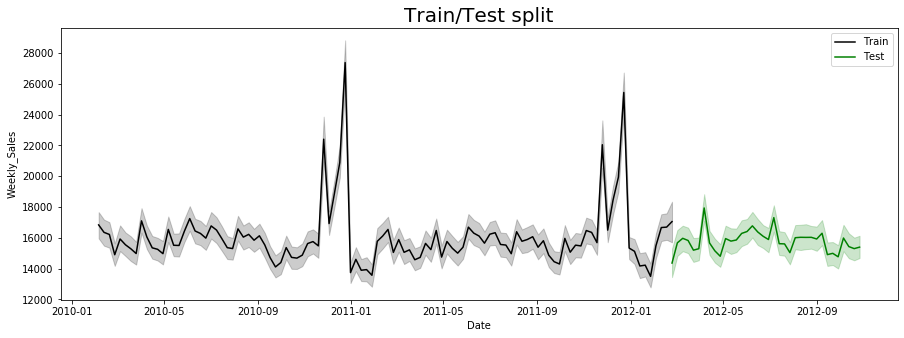

In [61]:
plt.figure(figsize=(15,5))
sns.lineplot(train.iloc[:int(len(X)*0.75),2],Y_train,color="k",label="Train")
sns.lineplot(train.iloc[int(len(X)*0.75):,2],Y_test,color="g",label="Test")
plt.title("Train/Test split",fontsize=20)
plt.show()

In [62]:
baseline=RandomForestRegressor(n_jobs=-1,n_estimators=20,random_state=26)
%time baseline.fit(X_train,Y_train)

CPU times: user 2min 21s, sys: 770 ms, total: 2min 22s
Wall time: 37.5 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=-1, oob_score=False,
                      random_state=26, verbose=0, warm_start=False)

In [63]:
Y_pred=baseline.predict(X_test)

In [64]:
WMAE(Y_test,Y_pred,X_test)

WMAE = 2040.9765328253093


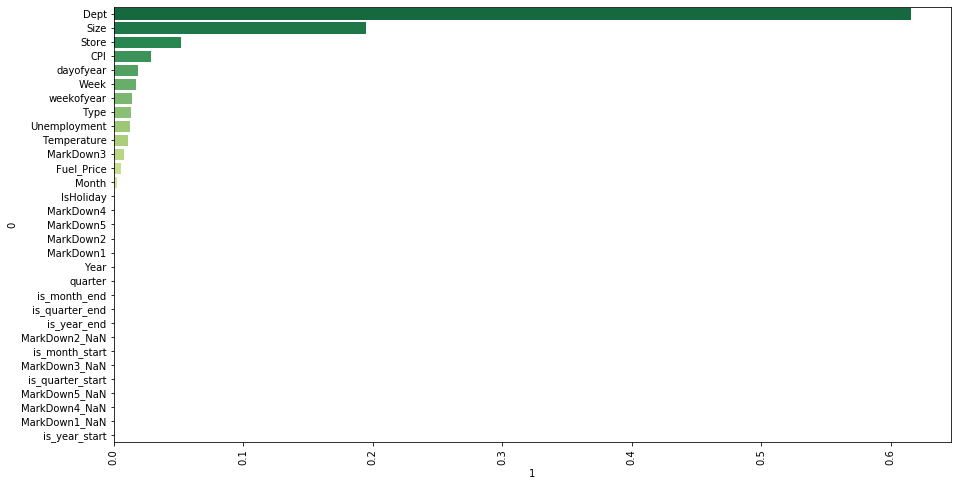

In [65]:
feature_imp=pd.DataFrame(list(zip(X.columns,baseline.feature_importances_))).sort_values(by=1,ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
plt.xticks(rotation=90)
plt.show()

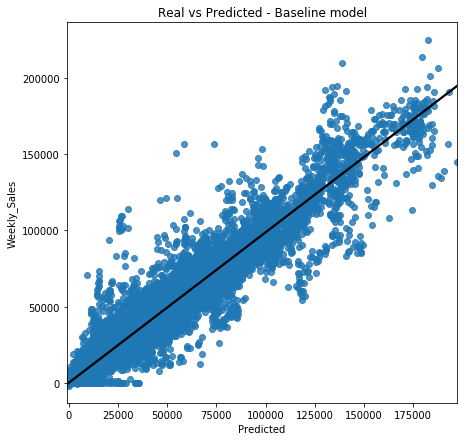

In [66]:
plt.figure(figsize=(7,7))
sns.regplot(Y_pred,Y_test, line_kws={"color":"k"})
plt.ylabel("Weekly_Sales")
plt.xlabel("Predicted")
plt.title("Real vs Predicted - Baseline model")
plt.show()

- Next, I will create a few new features and try to delete those who hasn't much importance.

# 3. Feature creation

## 3.1 Week before/after holiday
As we saw on the graphics in 1.3.3 section, people buy before holidays, so a good indicator might be this one

In [67]:
test=test.sort_values(by=["Year","Month","weekofyear"])

In [68]:
for s in train["Store"].unique():
    for d in train["Dept"].unique():
        train.loc[(train["Store"]==s)&(train["Dept"]==d),"Before"] = train[(train["Store"]==s)&(train["Dept"]==d)]["IsHoliday"].shift(-1)

In [69]:
for s in train["Store"].unique():
    for d in train["Dept"].unique():
        train.loc[(train["Store"]==s)&(train["Dept"]==d),"After"] = train[(train["Store"]==s)&(train["Dept"]==d)]["IsHoliday"].shift(1)

In [70]:
for s in test["Store"].unique():
    for d in test["Dept"].unique():
        test.loc[(test["Store"]==s)&(test["Dept"]==d),"Before"] = test[(test["Store"]==s)&(test["Dept"]==d)]["IsHoliday"].shift(-1)

In [71]:
for s in test["Store"].unique():
    for d in test["Dept"].unique():
        test.loc[(test["Store"]==s)&(test["Dept"]==d),"After"] = test[(test["Store"]==s)&(test["Dept"]==d)]["IsHoliday"].shift(1)

In [72]:
train["Before"].fillna(0,inplace=True)
train["After"].fillna(0,inplace=True)
test["Before"].fillna(0,inplace=True)
test["After"].fillna(0,inplace=True)

## 3.3 Days since last holiday

In [73]:
for s in train["Store"].unique():
    for d in train["Dept"].unique():
        last = np.nan
        for i in train[(train["Store"]==s)&(train["Dept"]==d)].index:
            if train.loc[i, "IsHoliday"] == 1:
                last = i
            train.loc[i, "weeks_since_last_holiday"] = i - last
    if s%5==0:
        print("Store {}, done".format(s))

Store 5, done
Store 10, done
Store 15, done
Store 20, done
Store 25, done
Store 30, done
Store 35, done
Store 40, done
Store 45, done


In [75]:
for s in test["Store"].unique():
    for d in test["Dept"].unique():
        last = np.nan
        for i in test[(test["Store"]==s)&(test["Dept"]==d)].index:
            if test.loc[i, "IsHoliday"] == 1:
                last = i
            test.loc[i, "weeks_since_last_holiday"] = i - last
    if s%5==0:
        print("Store {}, done".format(s))

Store 5, done
Store 10, done
Store 15, done
Store 20, done
Store 25, done
Store 30, done
Store 35, done
Store 40, done
Store 45, done


In [76]:
train["weeks_since_last_holiday"].fillna(int(train["weeks_since_last_holiday"].mean()),inplace=True)
test["weeks_since_last_holiday"].fillna(int(train["weeks_since_last_holiday"].mean()),inplace=True)

In [77]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,is_year_start,is_year_end,MarkDown1_NaN,MarkDown2_NaN,MarkDown3_NaN,MarkDown4_NaN,MarkDown5_NaN,Before,After,weeks_since_last_holiday
0,1,1,2010-02-05,24924.50,0,0,151315,42.31,2.572,0.00,...,False,False,True,True,True,True,True,1.0,0.0,10.0
143,1,2,2010-02-05,50605.27,0,0,151315,42.31,2.572,0.00,...,False,False,True,True,True,True,True,1.0,0.0,10.0
286,1,3,2010-02-05,13740.12,0,0,151315,42.31,2.572,0.00,...,False,False,True,True,True,True,True,1.0,0.0,10.0
429,1,4,2010-02-05,39954.04,0,0,151315,42.31,2.572,0.00,...,False,False,True,True,True,True,True,1.0,0.0,10.0
572,1,5,2010-02-05,32229.38,0,0,151315,42.31,2.572,0.00,...,False,False,True,True,True,True,True,1.0,0.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421012,45,93,2012-10-26,2487.80,0,1,118221,58.85,3.882,4018.91,...,False,False,False,False,False,False,False,0.0,0.0,7.0
421146,45,94,2012-10-26,5203.31,0,1,118221,58.85,3.882,4018.91,...,False,False,False,False,False,False,False,0.0,0.0,7.0
421289,45,95,2012-10-26,56017.47,0,1,118221,58.85,3.882,4018.91,...,False,False,False,False,False,False,False,0.0,0.0,7.0
421434,45,97,2012-10-26,6817.48,0,1,118221,58.85,3.882,4018.91,...,False,False,False,False,False,False,False,0.0,0.0,7.0


# 4. Hyper-parameter tunning

- I dont have a powerful computer, so I wasn't able to do a GridSearchCV and also to do Cross-Validation.
- In case of having a more powerful computer, we have to to do a GridSearchCV but its very important to do a TimeSplit crossvalidation.




In [82]:
X=train.drop(["Weekly_Sales","Date"],axis=1)
Y=train["Weekly_Sales"]
X_train=X.iloc[:int(len(X)*0.75),:]
X_test=X.iloc[int(len(X)*0.75):,:]
Y_train=Y[:int(len(Y)*0.75)]
Y_test=Y[int(len(Y)*0.75):]

In [83]:
tuned=RandomForestRegressor(n_estimators=50,min_samples_leaf=3,max_features=0.8)
%time tuned.fit(X_train,Y_train)

CPU times: user 2min 33s, sys: 544 ms, total: 2min 34s
Wall time: 2min 39s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

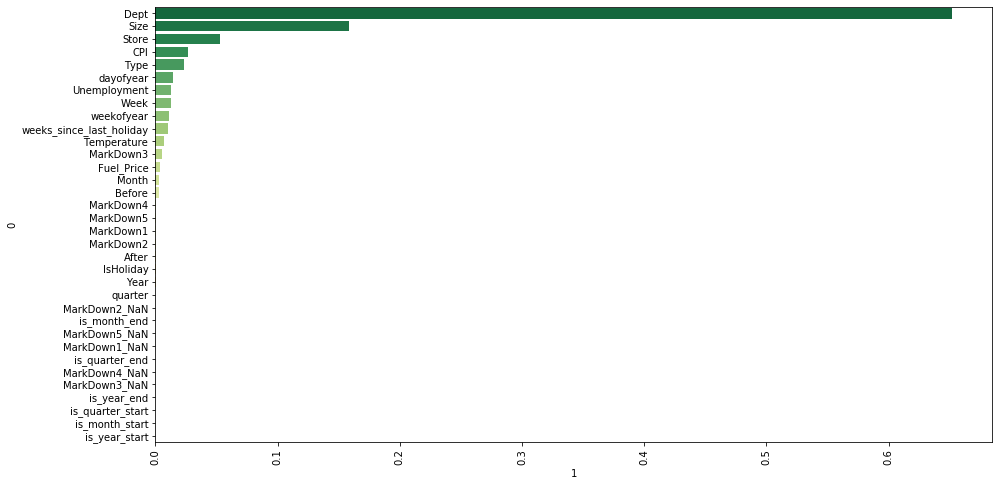

In [118]:
feature_imp=pd.DataFrame(list(zip(X.columns,tuned.feature_importances_))).sort_values(by=1,ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
plt.xticks(rotation=90)
plt.show()

In [85]:
Y_pred=tuned.predict(X_test)
WMAE(Y_test,Y_pred,X_test)

WMAE = 1896.0806797378307


In [87]:
print("The error decreased {}%".format(round((2041-1886)/2041,3)*100))

The error decreased 7.6%


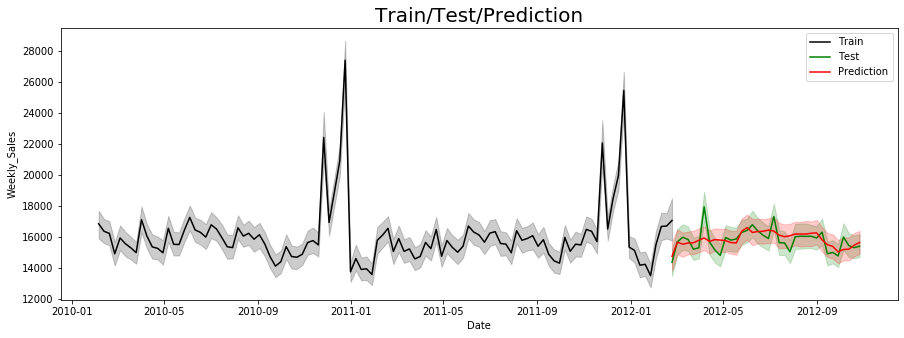

In [88]:
plt.figure(figsize=(15,5))
sns.lineplot(train.iloc[:int(len(X)*0.75),2],Y_train,color="k",label="Train")
sns.lineplot(train.iloc[int(len(X)*0.75):,2],Y_test,color="g",label="Test")
sns.lineplot(train.iloc[int(len(X)*0.75):,2],Y_pred,color="r",label="Prediction")
plt.title("Train/Test/Prediction",fontsize=20)
plt.show()

# 5. Tree-interpreter

In [89]:
import shap

In [113]:
test.sort_index().iloc[[8,7],:]

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,is_year_start,is_year_end,MarkDown1_NaN,MarkDown2_NaN,MarkDown3_NaN,MarkDown4_NaN,MarkDown5_NaN,Before,After,weeks_since_last_holiday
8,1,1,2012-12-28,1,0,151315,44.79,3.108,12659.55,37101.13,...,False,False,False,False,False,False,False,0.0,0.0,0.0
7,1,1,2012-12-21,0,0,151315,56.02,3.098,8231.71,0.00,...,False,False,False,True,False,False,False,1.0,0.0,4.0


In [90]:
explainer = shap.TreeExplainer(tuned)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [114]:
value = test[X_train.columns].loc[[7]]
shap_values = explainer.shap_values(value)

In [115]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], value)

In [116]:
value = test[X_train.columns].loc[[8]]
shap_values = explainer.shap_values(value)

In [117]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], value)

# 6. Submission

In [96]:
submission["Weekly_Sales"]=tuned.predict(test[X_train.columns].sort_index())

In [97]:
submission.to_csv("mysubmission.csv",index=False)

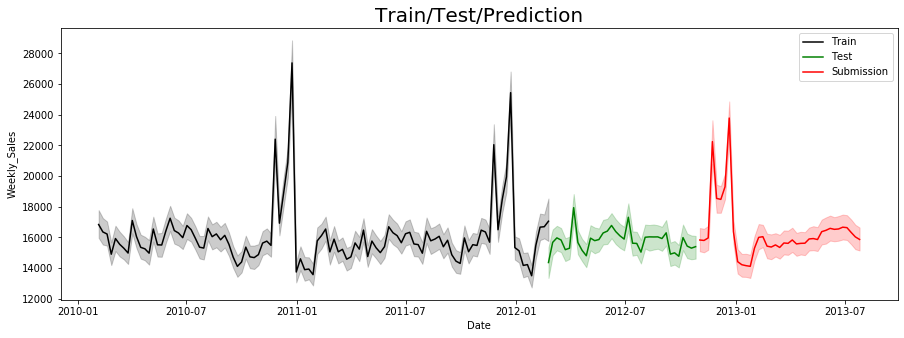

In [98]:
plt.figure(figsize=(15,5))
sns.lineplot(train.iloc[:int(len(X)*0.75),2],Y_train,color="k",label="Train")
sns.lineplot(train.iloc[int(len(X)*0.75):,2],Y_test,color="g",label="Test")
sns.lineplot(test.iloc[:,2],submission["Weekly_Sales"],color="r",label="Submission")
plt.title("Train/Test/Prediction",fontsize=20)
plt.show()